# Import Libraries

In [1]:
%load_ext tensorboard
from numpy.random import seed
seed(2)
#from tensorflow import set_random_seed
#set_random_seed(2)
import tensorflow as tf
from tensorflow import keras
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.data import Dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)


2.0.0


# Import Data

In [2]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

card_df = pd.read_excel("default of credit card clients.xls")
card_df = card_df.reindex(np.random.permutation(card_df.index))
card_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
7945,20000,2,2,1,37,0,0,2,0,0,...,19616,19228,19878,3200,0,830,750,1000,282,1
16536,500000,1,2,2,26,0,0,0,0,0,...,130136,127699,124623,6005,6005,6094,4161,5021,4350,0
26726,150000,1,1,2,26,-2,-1,0,0,-1,...,2360,70,420,360,1041,1000,70,660,0,0
16333,60000,2,2,1,36,0,0,0,0,0,...,41241,29534,29297,2000,3042,1433,1012,1029,1074,1
20629,220000,1,1,2,29,0,0,0,0,0,...,23965,23865,23667,1410,1417,1333,731,1019,1045,0


In [3]:
card_df.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
                             ..
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
Length: 24, dtype: int64

In [4]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 7945 to 23720
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1             

# Baseline Calculation

In [5]:
class_dist = 100*card_df['default payment next month'].value_counts()/len(card_df)
class_dist

0   77.9
1   22.1
Name: default payment next month, dtype: float64

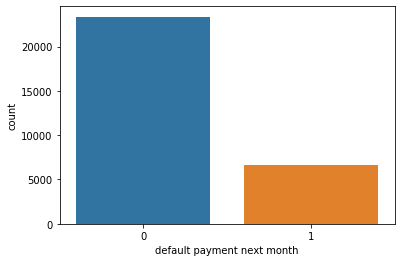

In [6]:
sns.countplot(x='default payment next month',data=card_df)

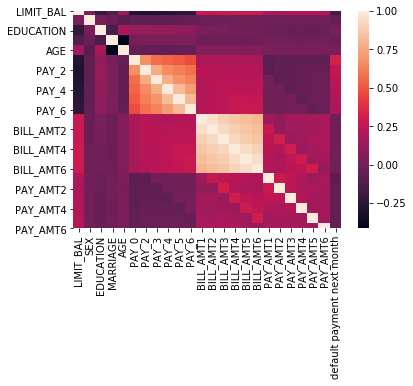

In [7]:
sns.heatmap(card_df.corr())

# Pre-Process Data

In [8]:
def preprocess_features(card_df):
    selected_features = card_df[
    ["LIMIT_BAL","SEX","EDUCATION","MARRIAGE","AGE","PAY_0","PAY_2","PAY_3","PAY_4",
    "PAY_5","PAY_6","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
    "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]]
    processed_features = selected_features.copy()
    return processed_features

def preprocess_targets(card_df):
  output_targets = card_df["default payment next month"]
  return output_targets

# Train/Validation Split

In [9]:
# Choose the first 83 examples for training.
training_examples = preprocess_features(card_df.head(24000))
training_targets = preprocess_targets(card_df.head(24000))
scaler = StandardScaler().fit(training_examples.values)
scaledf = scaler.transform(training_examples.values)
training_examples = pd.DataFrame(scaledf, index=training_examples.index, columns=training_examples.columns)


# Choose the 20 examples for validation.
validation_examples = preprocess_features(card_df.tail(6000))
vscaled = scaler.transform(validation_examples.values)
validation_examples = pd.DataFrame(vscaled, index=validation_examples.index, columns=validation_examples.columns)
validation_targets = preprocess_targets(card_df.tail(6000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,...,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0
mean,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.2,-1.2,-2.3,-3.0,-1.6,-1.8,-1.6,-1.5,-1.5,-1.5,...,-3.0,-3.3,-2.0,-6.4,-0.3,-0.2,-0.3,-0.3,-0.3,-0.3
25%,-0.9,-1.2,-1.1,-1.1,-0.8,-0.9,-0.7,-0.7,-0.7,-0.6,...,-0.6,-0.6,-0.6,-0.6,-0.3,-0.2,-0.3,-0.3,-0.3,-0.3
50%,-0.2,0.8,0.2,0.9,-0.2,0.0,0.1,0.1,0.2,0.2,...,-0.4,-0.4,-0.4,-0.4,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2
75%,0.6,0.8,0.2,0.9,0.6,0.0,0.1,0.1,0.2,0.2,...,0.2,0.2,0.2,0.2,-0.0,-0.0,-0.0,-0.1,-0.1,-0.1
max,6.4,0.8,5.2,2.8,4.7,7.1,6.8,6.8,7.0,7.3,...,23.4,13.2,14.7,15.5,51.4,68.4,49.6,39.0,26.9,29.4


Validation examples summary:


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,...,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0
mean,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.9,0.6,0.9,1.0,0.9,1.0
min,-1.2,-1.2,-2.3,-3.0,-1.6,-1.8,-1.6,-1.5,-1.5,-1.5,...,-1.0,-1.4,-1.4,-3.2,-0.3,-0.2,-0.3,-0.3,-0.3,-0.3
25%,-0.8,-1.2,-1.1,-1.1,-0.8,-0.9,-0.7,-0.7,-0.7,-0.6,...,-0.6,-0.6,-0.6,-0.6,-0.3,-0.2,-0.3,-0.3,-0.3,-0.3
50%,-0.2,0.8,0.2,0.9,-0.2,0.0,0.1,0.1,0.2,0.2,...,-0.4,-0.4,-0.4,-0.4,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2
75%,0.6,0.8,0.2,0.9,0.6,0.0,0.1,0.1,0.2,0.2,...,0.2,0.2,0.2,0.2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.1
max,4.9,0.8,5.2,2.8,4.1,7.1,5.9,6.0,6.1,6.4,...,9.4,10.3,12.9,7.8,23.6,14.4,20.4,33.2,19.9,24.6


Training targets summary:


count   24000.0
mean        0.2
std         0.4
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         1.0
Name: default payment next month, dtype: float64

Validation targets summary:


count   6000.0
mean       0.2
std        0.4
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        1.0
Name: default payment next month, dtype: float64

# Build Model

In [10]:
training_examples.shape

(24000, 23)

In [11]:
baseline_model = keras.Sequential([
    keras.layers.Dense(80, activation = tf.nn.relu, input_shape = (training_examples.shape[1],)),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(27, activation=tf.nn.relu,),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(13, activation=tf.nn.relu,),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation='sigmoid')
  ])


baseline_model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['accuracy'])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                1920      
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                2187      
_________________________________________________________________
dropout_1 (Dropout)          (None, 27)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                364       
_________________________________________________________________
dropout_2 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [12]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=3)
EPOCHS = 100
b_history = baseline_model.fit(training_examples,training_targets,epochs=EPOCHS,
                   validation_data= (validation_examples, validation_targets),verbose=2,
                               callbacks=[early_stopping_monitor])





Using TensorFlow backend.


Train on 24000 samples, validate on 6000 samples
Epoch 1/100
24000/24000 - 5s - loss: 0.5152 - accuracy: 0.7860 - val_loss: 0.4568 - val_accuracy: 0.8095
Epoch 2/100
24000/24000 - 4s - loss: 0.4702 - accuracy: 0.8108 - val_loss: 0.4492 - val_accuracy: 0.8112
Epoch 3/100
24000/24000 - 3s - loss: 0.4572 - accuracy: 0.8112 - val_loss: 0.4453 - val_accuracy: 0.8127
Epoch 4/100
24000/24000 - 3s - loss: 0.4541 - accuracy: 0.8113 - val_loss: 0.4482 - val_accuracy: 0.8053
Epoch 5/100
24000/24000 - 3s - loss: 0.4502 - accuracy: 0.8140 - val_loss: 0.4422 - val_accuracy: 0.8153
Epoch 6/100
24000/24000 - 3s - loss: 0.4468 - accuracy: 0.8139 - val_loss: 0.4429 - val_accuracy: 0.8177
Epoch 7/100
24000/24000 - 3s - loss: 0.4436 - accuracy: 0.8165 - val_loss: 0.4441 - val_accuracy: 0.8110
Epoch 8/100
24000/24000 - 4s - loss: 0.4425 - accuracy: 0.8135 - val_loss: 0.4417 - val_accuracy: 0.8160
Epoch 9/100
24000/24000 - 4s - loss: 0.4420 - accuracy: 0.8165 - val_loss: 0.4426 - val_accuracy: 0.8192
Epoch 

In [15]:
print(max(b_history.history['val_accuracy']))

0.81916666


In [16]:
losses_df = pd.DataFrame(b_history.history)
losses_df

,loss,accuracy,val_loss,val_accuracy
0,0.5,0.8,0.5,0.8
1,0.5,0.8,0.4,0.8
2,0.5,0.8,0.4,0.8
3,0.5,0.8,0.4,0.8
4,0.5,0.8,0.4,0.8
...,...,...,...,...
6,0.4,0.8,0.4,0.8
7,0.4,0.8,0.4,0.8
8,0.4,0.8,0.4,0.8
9,0.4,0.8,0.4,0.8


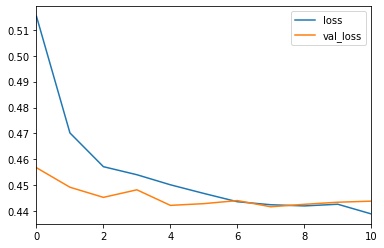

In [17]:
losses_df[['loss','val_loss']].plot()

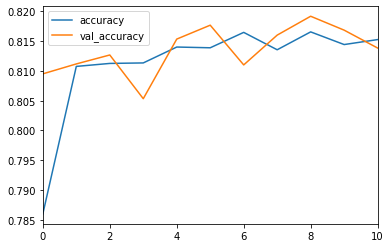

In [18]:
losses_df[['accuracy','val_accuracy']].plot()

In [19]:
from sklearn.metrics import classification_report,confusion_matrix

In [20]:
predictions = baseline_model.predict_classes(validation_examples)

In [21]:
print(classification_report(validation_targets,predictions))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4672
           1       0.69      0.28      0.40      1328

    accuracy                           0.81      6000
   macro avg       0.76      0.62      0.65      6000
weighted avg       0.80      0.81      0.78      6000

